In [4]:
import torch
from torch import nn,optim
import torchvision
import torch.nn.functional as F

### 定义AlexNet网络

In [7]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__() #继承alexnet的属性并初始化
        self.conv = nn.Sequential(
                nn.Conv2d(1,32,3,1),#输入通道为1，输出通道为32，采用3*3的卷积核，步长为1,padding_size
                nn.MaxPool2d(2,2),#2*2的核，步长2
                nn.ReLU(),
                # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增加输出通道数 
                nn.Conv2d(32,64,3,1,1),
                nn.MaxPool2d(2,2),#2*2的核，步长2
                nn.ReLU(),
                # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增加了输出通道数。
                # 前两个卷积层后不使用池化层来减小输入的⾼和宽  
                nn.Conv2d(64,128,3,1,1),
                nn.Conv2d(128,256,3,1,1),
                nn.Conv2d(256,256,3,1,1),
                nn.MaxPool2d(2,2),
                nn.ReLU()
                )
        # 这里全连接层的输出个数 ALexNet中的数倍。使用dropout来缓解过拟合。
        self.fc = nn.Sequential(
            # 输出层，10分类
                nn.Linear(256*3*3, 1024), 
                nn.Linear(1024, 512),
                nn.Linear(512, 10),
                )
      #定义全连接层  
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [8]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#定义超参数
EPOCH = 10
BATCH_SIZE = 32 
LR = 0.001
DOWNLOR_MNIST = True

In [10]:
#下载数据集
train_data = datasets.MNIST(root='/nas/mnist/',
                         train=True,                         # 这里是训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transforms.ToTensor(), 
                         download=DOWNLOR_MNIST
                        # 将PIL Image或者numpy.ndarray转化为torch.FloatTensor，shape为(C,H,W)，并且归一化到[0.0, 1.0]
                        )

test_data = datasets.MNIST(root='/nas/mnist/',
                        download=DOWNLOR_MNIST,
                        train=False,                         # 测试集
                        transform=transforms.ToTensor()
                        )

Extracting /nas/mnist/MNIST\raw\train-images-idx3-ubyte.gz to /nas/mnist/MNIST\raw


Extracting /nas/mnist/MNIST\raw\train-labels-idx1-ubyte.gz to /nas/mnist/MNIST\raw


Extracting /nas/mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to /nas/mnist/MNIST\raw


Extracting /nas/mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to /nas/mnist/MNIST\raw
Processing...
Done!


In [11]:
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]

D:\Program Files\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\Program Files\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


训练集大小： torch.Size([60000, 28, 28])
训练集标签个数： torch.Size([60000])


D:\Program Files\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\Program Files\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


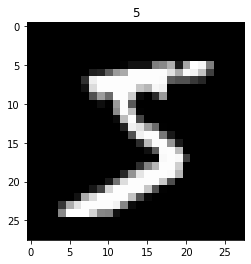

In [12]:
#显示一张图片
print('训练集大小：', train_data.train_data.size())     # 查看训练集数据大小，60000张28*28的图片 (60000, 28, 28)
print('训练集标签个数：', train_data.train_labels.size())   # 查看训练集标签大小，60000个标签 (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray') # plot 训练集第一张图片
plt.title('%i' % train_data.train_labels[0])              # 图片名称，显示真实标签，%i %d十进制整数，有区别，深入请查阅资料
plt.show()

In [13]:
#分批加载数据
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader  = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)

In [14]:
model = AlexNet()
#损失函数采用logloss交叉熵
criterion = nn.CrossEntropyLoss()
#优化器采用SGD
optimizer = optim.Adam(model.parameters(),lr = LR)

In [15]:
#可以采用GPU训练
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
model.to(device)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [16]:
#开始训练
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
    print('epoch{} loss:{:.4f}'.format(epoch+1, loss.item()))

print("Finished Traning")

epoch1 loss:0.2364
epoch2 loss:0.0440
epoch3 loss:0.1531
epoch4 loss:0.0010
epoch5 loss:0.1869
epoch6 loss:0.0499
epoch7 loss:0.1734
epoch8 loss:0.0687
epoch9 loss:0.0006
epoch10 loss:0.0335
Finished Traning


In [17]:
#保存模型
torch.save(model, 'mnist_alexnet.pt')
model = torch.load('mnist_alexnet.pt')

D:\Program Files\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

10000测试图像 准确率:98.7100%
